# COURSE: A deep understanding of deep learning
## SECTION: Weight inits and investigations
### LECTURE: Weight characteristics during learning
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# # import dataset (comes with colab!)
# data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# # extract labels (number IDs) and remove from data
# labels = data[:,0]
# data   = data[:,1:]

# # normalize the data to a range of [0 1]
# dataNorm = data / np.max(data)

# import dataset from torchvision
import torchvision.datasets as datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)

train_data = mnist_train.data
train_labels = mnist_train.targets
test_data = mnist_test.data
test_labels = mnist_test.targets

# reshape data to 2D tensor
train_data = train_data.reshape(-1, 28*28).float()
test_data = test_data.reshape(-1, 28*28).float()

labels = torch.cat((train_labels, test_labels), dim=0)
data = torch.cat((train_data, test_data), dim=0)

# extract labels (number IDs) and remove from data
# labels = data[:,0]
# data   = data[:,1:]

dataNorm = data / np.max(data.numpy())

labelsPy = labels.numpy()
dataPy = data.numpy()

print(dataNorm.shape)
print(labels.shape)

torch.Size([70000, 784])
torch.Size([70000])


In [3]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

/tmp/ipykernel_46332/4159625118.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataT   = torch.tensor( dataNorm ).float()
/tmp/ipykernel_46332/4159625118.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labelsT = torch.tensor( labels ).long()


# Create the DL model

In [4]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (Note: SGD to slow down learning!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# Create a function that trains the model

In [5]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 60
  
  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # initialize weight change matrices
  # We have a 4 because we have 4 layers (input, hidden1, hidden2, output)
  weightChange = np.zeros((numepochs,4)) # Euclidean Distance
  weightConds  = np.zeros((numepochs,4)) # Condition Number

  # loop over epochs
  for epochi in range(numepochs):

    # store the weights for each layer
    preW = []
    for p in net.named_parameters():
      if 'weight' in p[0]:
        preW.append( copy.deepcopy(p[1].data.numpy()) )


    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )


    # finally, get the post-learning state of the weights
    # in weightConds and Change, i/2 because we have weight and bias, and we are only getting weight
    # in preW, because we want to get the values of the weights before the training
    for (i,p) in enumerate(net.named_parameters()):
      if 'weight' in p[0]:
        # condition number
        weightConds[epochi,int(i/2)]  = np.linalg.cond(p[1].data)

        # Frobenius norm of the weight change from pre-learning
        weightChange[epochi,int(i/2)] = np.linalg.norm( preW[int(i/2)]-p[1].data.numpy(), ord='fro')

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,weightChange,weightConds,preW

# Run the model and plot the results

In [6]:
# create the network
net,lossfun,optimizer = createTheMNISTNet()

# train the model
trainAcc,testAcc,losses,net,weightChange,weightConds,preW = function2trainTheModel(net,lossfun,optimizer)

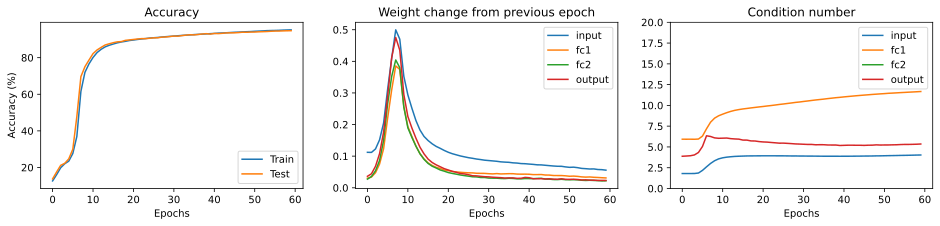

In [9]:
# Show the results!

# get a list of layer names
layername = []
for (i,p) in enumerate(net.named_parameters()):
  if 'weight' in p[0]:
    layername.append(p[0][:-7])


# set up the plot
fig,ax = plt.subplots(1,3,figsize=(16,3))

# accuracy
ax[0].plot(trainAcc)
ax[0].plot(testAcc)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Accuracy')
ax[0].legend(['Train','Test'])

# weight changes
ax[1].plot(weightChange)
ax[1].set_xlabel('Epochs')
ax[1].set_title('Weight change from previous epoch')
ax[1].legend(layername)

# weight condition numbers
ax[2].plot(weightConds)
ax[2].set_xlabel('Epochs')
ax[2].set_title('Condition number')
ax[2].legend(layername)
ax[2].set_ylim([0,20]) # Comment this for surprise

plt.show()

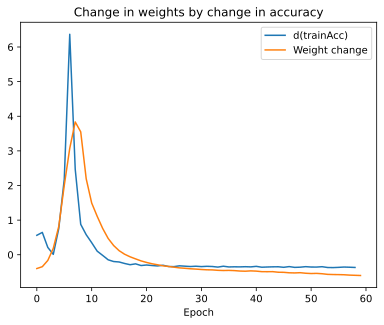

In [10]:
# final inspection: check the derivative of accuracy against the weight change
from scipy.stats import zscore # normalize for scaling offsets

plt.plot(zscore(np.diff(trainAcc)),label='d(trainAcc)')
plt.plot(zscore(np.mean(weightChange,axis=1)),label='Weight change')
plt.legend()
plt.title('Change in weights by change in accuracy')
plt.xlabel('Epoch')
plt.show()

# Additional explorations

In [ ]:
# 1) Re-run the training and visualization with L2 regularization (lambda=.01). Does that have a major noticeable effect?
# 
# 2) Then try with L1 regularization. (Hint: you might want to copy code from DUDL_overfitting_L1regu).
# 